In [22]:
import torch
from transformers import AutoTokenizer, AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load PhoBERT
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)
phobert = AutoModel.from_pretrained("vinai/phobert-base").to(device)

def get_combined_question_features(questions):
    """
    ✅ Tổng hợp nhiều câu hỏi thành một embedding duy nhất.
    """
    encoded_inputs = tokenizer(questions, return_tensors="pt", padding=True, truncation=True, max_length=128)
    encoded_inputs = {k: v.to(device) for k, v in encoded_inputs.items()}
    outputs = phobert(**encoded_inputs)
    
    # Trung bình cộng đặc trưng từ tất cả câu hỏi
    combined_features = outputs.last_hidden_state[:, 0, :].mean(dim=0)
    return combined_features

# ✅ Ví dụ: So sánh giữa 3 và 5 câu hỏi
questions_3 = ["sản phẩm có tên là gì?", "sản phẩm này được gọi là gì?", "Tên gọi của nó là gì?"]
questions_5 = ["Sản phẩm này có liên quan đến khu vực nào?", "sản phẩm này được gọi là gì?", "Tên gọi của nó là gì?", "Sản phẩm này có xuất xứ từ địa phương nào?", "Sản phẩm này phổ biến nhất ở đâu?"]

features_3 = get_combined_question_features(questions_3)
features_5 = get_combined_question_features(questions_5)

print("🎯 Đặc trưng từ 3 câu hỏi:", features_3.shape)
print("🎯 Đặc trưng từ 5 câu hỏi:", features_5.shape)


🎯 Đặc trưng từ 3 câu hỏi: torch.Size([768])
🎯 Đặc trưng từ 5 câu hỏi: torch.Size([768])


In [19]:
import pandas as pd
import os

def sort_image_paths_by_folder_and_filename(csv_file):
    """
    ✅ Sắp xếp đường dẫn ảnh theo:
    1. Thư mục sản phẩm (ví dụ: 'bi', 'cha_gan', v.v.)
    2. Tên file theo thứ tự thời gian hoặc chữ cái.

    Args:
        csv_file (str): Đường dẫn file CSV chứa cột 'image_path'.

    Returns:
        DataFrame: Dữ liệu đã sắp xếp.
    """
    # Đọc dữ liệu từ CSV
    df = pd.read_csv(csv_file)

    # Kiểm tra cột 'image_path'
    if 'image_path' not in df.columns:
        raise ValueError("⚠️ File CSV phải có cột 'image_path'.")

    # Trích xuất tên thư mục sản phẩm và tên file
    df['product_folder'] = df['image_path'].apply(lambda x: os.path.normpath(x).split(os.sep)[-2])  # Lấy thư mục ngay trước tên file
    df['filename'] = df['image_path'].apply(lambda x: os.path.basename(x))

    # Sắp xếp theo thư mục và tên file
    df_sorted = df.sort_values(by=['product_folder', 'filename'], ascending=[True, True])

    # Xóa cột phụ trợ nếu không cần
    df_sorted.drop(columns=['product_folder', 'filename'], inplace=True)

    return df_sorted

# ------------------------------
# 📂 Ví dụ sử dụng hàm
# ------------------------------

# Đường dẫn đến file CSV chứa cột 'image_path'
csv_file = r"C:\HOCTAP\Back-end\mohinh\items\data\data2\train_kaggle_sort.csv"  # Thay đường dẫn phù hợp

# Gọi hàm để sắp xếp
sorted_df = sort_image_paths_by_folder_and_filename(csv_file)

# Hiển thị kết quả
print("📊 Đường dẫn ảnh sau khi sắp xếp:")
print(sorted_df.head(20))

# Lưu file CSV mới nếu cần
sorted_df.to_csv(r"C:\HOCTAP\Back-end\mohinh\items\data\data2\train_kaggle_sort1.csv", index=False)
print("\n💾 Đã lưu file đã sắp xếp tại: C:\HOCTAP\Back-end\mohinh\items\data\data2\train_kaggle_sort1.csv")


📊 Đường dẫn ảnh sau khi sắp xếp:
                                             image_path product  \
361   /kaggle/input/data-luan-van/image/image/bi/202...      bi   
1178  /kaggle/input/data-luan-van/image/image/bi/202...      bi   
1492  /kaggle/input/data-luan-van/image/image/bi/202...      bi   
630   /kaggle/input/data-luan-van/image/image/bi/202...      bi   
893   /kaggle/input/data-luan-van/image/image/bi/202...      bi   
1386  /kaggle/input/data-luan-van/image/image/bi/202...      bi   
1172  /kaggle/input/data-luan-van/image/image/bi/202...      bi   
1536  /kaggle/input/data-luan-van/image/image/bi/202...      bi   
957   /kaggle/input/data-luan-van/image/image/bi/202...      bi   
1506  /kaggle/input/data-luan-van/image/image/bi/202...      bi   
592   /kaggle/input/data-luan-van/image/image/bi/202...      bi   
1877  /kaggle/input/data-luan-van/image/image/bi/202...      bi   
389   /kaggle/input/data-luan-van/image/image/bi/202...      bi   
1874  /kaggle/input/data-luan

In [18]:
import pandas as pd

# Đọc file CSV (cập nhật đường dẫn file của bạn)
csv_path = r"C:\HOCTAP\Back-end\mohinh\items\data\data2\train_kaggle_sort.csv"
df = pd.read_csv(csv_path)

# Kiểm tra các cột có trong file
print("📋 Các cột trong file CSV:", df.columns.tolist())

# -------------------------
# ✅ Đếm số lần xuất hiện của mỗi câu hỏi trong từng sản phẩm
# -------------------------

# Nhóm dữ liệu theo 'product' và 'question', sau đó đếm số lần xuất hiện
question_counts_per_product = df.groupby(['product', 'question']).size().reset_index(name='count')

# Lọc ra các câu hỏi trùng lặp (xuất hiện nhiều hơn 1 lần trong sản phẩm)
duplicate_questions_per_product = question_counts_per_product[question_counts_per_product['count'] > 1]

# Hiển thị kết quả
print("\n📊 Các câu hỏi trùng nhau trong từng sản phẩm và số lần xuất hiện:")
print(duplicate_questions_per_product)

# -------------------------
# ✅ Hiển thị chi tiết theo từng sản phẩm
# -------------------------
for product in duplicate_questions_per_product['product'].unique():
    product_data = duplicate_questions_per_product[duplicate_questions_per_product['product'] == product]
    print(f"\n🔖 Sản phẩm: {product}")
    for _, row in product_data.iterrows():
        print(f"➡️ Câu hỏi: '{row['question']}' xuất hiện {row['count']} lần")

# -------------------------
# ✅ Lưu kết quả ra file CSV nếu cần
# -------------------------
output_path = r"C:\HOCTAP\Back-end\mohinh\items\data\data2\duplicate_questions_per_product.csv"
duplicate_questions_per_product.to_csv(output_path, index=False)
print(f"\n💾 Kết quả đã lưu tại: {output_path}")


📋 Các cột trong file CSV: ['image_path', 'product', 'question', 'answer', 'question_type']

📊 Các câu hỏi trùng nhau trong từng sản phẩm và số lần xuất hiện:
      product                                           question  count
0          bi                         Cha đẻ của sản phẩm ở đâu?     21
1          bi  Chính sách bảo hành và đổi trả sản phẩm này ra...     39
2          bi       Chính sách đổi trả sản phẩm lỗi như thế nào?     44
3          bi  Chất lượng của nguyên liệu trong sản phẩm này ...     25
4          bi                     Cái này có tên gọi khác không?     50
..        ...                                                ...    ...
403  nem_chua      Sử dụng sản phẩm bị hỏng có gây hại gì không?     35
404  nem_chua                        Tên chính xác của nó là gì?     44
405  nem_chua                             Tên của cái này là gì?     41
406  nem_chua  Tại sao sản phẩm này có thể bị hỏng trước hạn ...     56
407  nem_chua  Đóng gói sản phẩm này có tuân theo 

In [27]:
import pandas as pd

# Đọc file CSV (cập nhật đường dẫn file của bạn)
csv_path = r"C:\HOCTAP\Back-end\mohinh\items\data\data2\train_kaggle_sort.csv"
df = pd.read_csv(csv_path)

# Giả sử cột chứa câu hỏi có tên là 'question'
# Đếm số lần xuất hiện của mỗi câu hỏi
question_counts = df['question'].value_counts()

# Lọc ra các câu hỏi trùng nhau (xuất hiện nhiều hơn 1 lần)
duplicate_questions = question_counts[question_counts > 1]

print("Các câu hỏi trùng nhau và số lần xuất hiện:")
print(duplicate_questions)

# Nếu bạn muốn in ra danh sách các câu hỏi duy nhất và số lần lặp lại của chúng:
for question, count in duplicate_questions.items():
    print(f"Câu hỏi: '{question}' xuất hiện {count} lần")


Các câu hỏi trùng nhau và số lần xuất hiện:
Những nguyên nhân nào có thể khiến sản phẩm bị hỏng?                           330
Tên chính xác của nó là gì?                                                    329
Sản phẩm lỗi có được hoàn tiền thay vì đổi mới không?                          327
Những thành phần nào trong sản phẩm dễ bị phân hủy nhất?                       325
Nguyên liệu trong sản phẩm này có được kiểm định không?                        325
Có cần yêu cầu đặc biệt nào khi đóng gói sản phẩm này không?                   320
Quy trình chế biến sản phẩm này như thế nào?                                   320
Cái này có tên gọi khác không?                                                 319
Chính sách đổi trả sản phẩm lỗi như thế nào?                                   318
Có cơ quan nào cấp phép và chứng nhận cho nguyên liệu này không?               318
Tại sao sản phẩm này có thể bị hỏng trước hạn sử dụng?                         315
Sản phẩm này có cần bảo quản đặc biệt sau k

🔍 Tổng số dòng dữ liệu: 15103
🖼️ Số đường dẫn ảnh khác nhau: 7034

📊 Số lượng ảnh theo từng loại sản phẩm:
bi          1888
cha_gan     1888
cha_hoa     1888
cha_lua     1888
cha_que     1888
do_nguoi    1888
nem_chua    1888
moc         1887
Name: product, dtype: int64


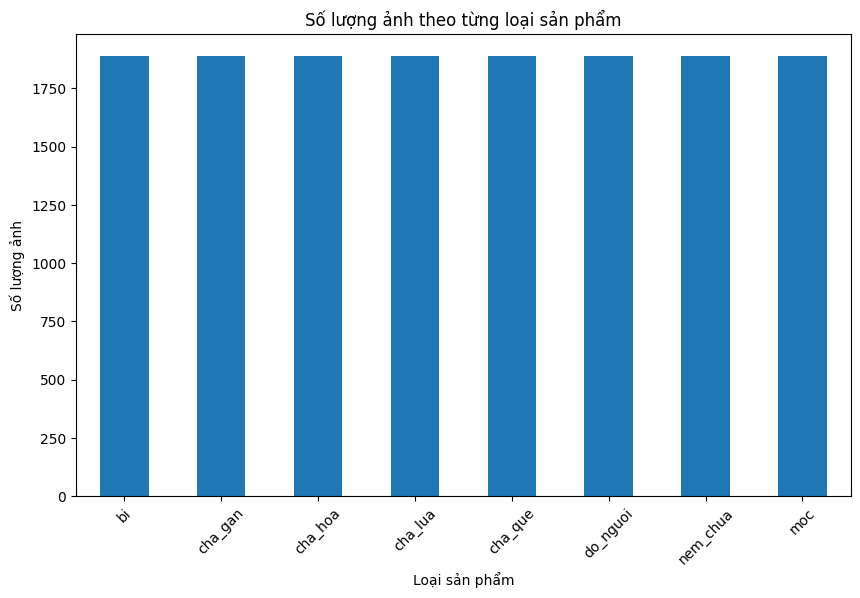

In [1]:
import pandas as pd

# ✅ Đọc dữ liệu từ file CSV
csv_file = r"C:\HOCTAP\Back-end\mohinh\items\data\train_kaggle_sort.csv"  # Thay bằng đường dẫn file của bạn
df = pd.read_csv(csv_file)

# ✅ Kiểm tra thông tin tổng quan
print(f"🔍 Tổng số dòng dữ liệu: {len(df)}")

# ✅ Đếm số đường dẫn ảnh khác nhau
unique_image_paths = df['image_path'].nunique()
print(f"🖼️ Số đường dẫn ảnh khác nhau: {unique_image_paths}")

# ✅ Đếm số lượng ảnh theo từng loại sản phẩm
product_counts = df['product'].value_counts()
print("\n📊 Số lượng ảnh theo từng loại sản phẩm:")
print(product_counts)

# ✅ Kiểm tra nếu có sản phẩm ngoài 8 loại
if len(product_counts) > 8:
    print(f"\n⚠️ Có nhiều hơn 8 loại sản phẩm! Số loại hiện tại: {len(product_counts)}")
elif len(product_counts) < 8:
    print(f"\n⚠️ Thiếu loại sản phẩm! Chỉ có {len(product_counts)} loại trong dữ liệu.")

# ✅ (Tùy chọn) Vẽ biểu đồ số lượng ảnh theo loại sản phẩm
import matplotlib.pyplot as plt

product_counts.plot(kind='bar', figsize=(10,6))
plt.title("Số lượng ảnh theo từng loại sản phẩm")
plt.xlabel("Loại sản phẩm")
plt.ylabel("Số lượng ảnh")
plt.xticks(rotation=45)
plt.show()
